In [1]:
import os
import glob as glob

import matplotlib.pyplot as plt
#$%matplotlib inline

import pandas as pd
import numpy as np

import nibabel as nib
import nipype.interfaces.fsl as fsl
from nilearn import image, plotting
from nistats.design_matrix import make_first_level_design_matrix
from nistats.reporting import plot_design_matrix,  plot_contrast_matrix
from nistats.first_level_model import FirstLevelModel
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

from confounds_prep import *
from multi_logging import *


/home/finc/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/finc/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
fmri_dir = f'/home/finc/Dropbox/Projects/SelfReg/data/neuroimaging/derivatives/' 
beh_dir = f'/home/finc/Dropbox/Projects/SelfReg/data/behavioral/prep/'
out_dir = f'/home/finc/Dropbox/Projects/SelfReg/data/neuroimaging/1stlevel_surveyMedley/'

task = 'surveyMedley'

%run multi_logging.py

subs_list = os.listdir(fmri_dir)
sub = 'sub-s358'
    

Loading fMRI data
=============================

In [3]:
tr = 0.68
n_trials = 40

try :
    fmri = glob.glob(f'{fmri_dir}{sub}/*{task}*bold_space-MNI152NLin2009cAsym_preproc.nii.gz')[0]
    fmri_img = nib.load(fmri)
    n_scans = fmri_img.shape[3]

    new_dir = f'{out_dir}{sub}/'
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    if not os.path.exists(f'{new_dir}figures'):
        os.makedirs(f'{new_dir}figures')

except IndexError:
    logger(sub, 'info', 'log_fmri')

Design matrix preparation
==============================

In [4]:
try :
    events_prep = pd.read_csv(f'{beh_dir}{sub}/{sub}_{task}_clean.csv')
    frame_times = np.arange(n_scans) * tr
    events = pd.DataFrame(events_prep, columns=['onset', 'trial_type', 'duration'])

    events_path = f'{out_dir}{sub}/{sub}_{task}_events.csv'

    if not os.path.exists(events_path):
        events.to_csv(events_path, index = False)

    n = len(np.unique(events['trial_type']))
    assert n == n_trials,  f'Wrong number of qestions for {sub}. Should be {n_trials}, but is {n}'
    assert events.isnull().sum().values.sum() == 0,  f'Not a number values in events for {sub}.'

except (IndexError, AssertionError) as e:
     logger(sub, 'info', 'log_events')

events.head()

onset trial_type  duration
0   1.006        Q15     3.982
1  10.077        Q39     3.982
2  20.371        Q31     3.982
3  32.161        Q09     3.982
4  41.368        Q37     3.982

Confounds preparation
==============================

In [5]:
try :
    confounds = pd.read_csv(glob.glob(f'{fmri_dir}{sub}/*surveyMedley*.tsv')[0],  sep = '\t')
    confounds_clean = confounds_prep(confounds)                             

    n_outliers = sum(confounds_clean['scrubbing'])
    perc_ouliers = (n_outliers/n_scans)*100
    confounds_path = f'{out_dir}{sub}/{sub}_{task}_confounds_clean.csv'
    if not os.path.exists(confounds_path):
        confounds_clean.to_csv(confounds_path, index = False)

except IndexError:
     logger(sub, 'info', 'log_confounds')

        
try :    
    fd = confounds['FramewiseDisplacement'].copy()
    mean_fd = fd.values[1:].mean(axis=0)
    
    assert perc_ouliers < 15,  f'More than 15% outliers for {sub}'
    assert  mean_fd < 0.5,  f'Mean FD higher than 0.5 mm for {sub}'
    
except  AssertionError:
    logger(sub, 'info', 'log_motion')
    
confounds_clean.head()

/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/finc/Dropbox/Projects/SelfReg/code/Self_Regulation_Ontology_Survey_fMRI/confounds_prep.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  confounds_fd_dvars.iloc[0,:] = [0, 0]


X         Y         Z      RotX      RotY      RotZ      X_td  \
0 -0.007383 -0.009284 -0.065939  0.000000  0.000195 -0.000239  0.000000   
1 -0.007773 -0.036050 -0.074774  0.000000  0.000276 -0.000181 -0.000389   
2  0.000032 -0.063143 -0.074306 -0.000289  0.000255  0.000000  0.007805   
3 -0.000132 -0.063158 -0.048765 -0.000419  0.000240 -0.000160 -0.000164   
4 -0.007949 -0.045443 -0.032768 -0.000517  0.000175 -0.000127 -0.007818   

       Y_td      Z_td   RotX_td    ...       RotZ_td  aCompCor00  aCompCor01  \
0  0.000000  0.000000  0.000000    ...      0.000000   -0.100830    0.047423   
1 -0.026766 -0.008836  0.000000    ...      0.000058   -0.098955   -0.006465   
2 -0.027093  0.000469 -0.000289    ...      0.000181   -0.103895   -0.069051   
3 -0.000015  0.025541 -0.000130    ...     -0.000160   -0.096349    0.058122   
4  0.017715  0.015997 -0.000099    ...      0.000033   -0.075359   -0.023215   

   aCompCor02  aCompCor03  aCompCor04  aCompCor05  stdDVARS  \
0   -0.035980    0.005844   -0.012293    0.018833  0.000000   
1   -0.006977   -0.045457   -0.054359    0.013550  1.026927   
2   -0.039147    0.023716   -0.042529   -0.025206  1.063310   
3   -0.015596   -0.012985   -0.025175   -0.005330  1.269590   
4    0.002672   -0.048294   -0.028306    0.008633  1.039959   

   FramewiseDisplacement  scrubbing  
0               0.000000          0  
1               0.042951          0  
2               0.059959          0  
3               0.040944          0  
4               0.051341          0  

[5 rows x 21 columns]

Fitrst level analysis
=================================

/home/finc/anaconda/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/finc/anaconda/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


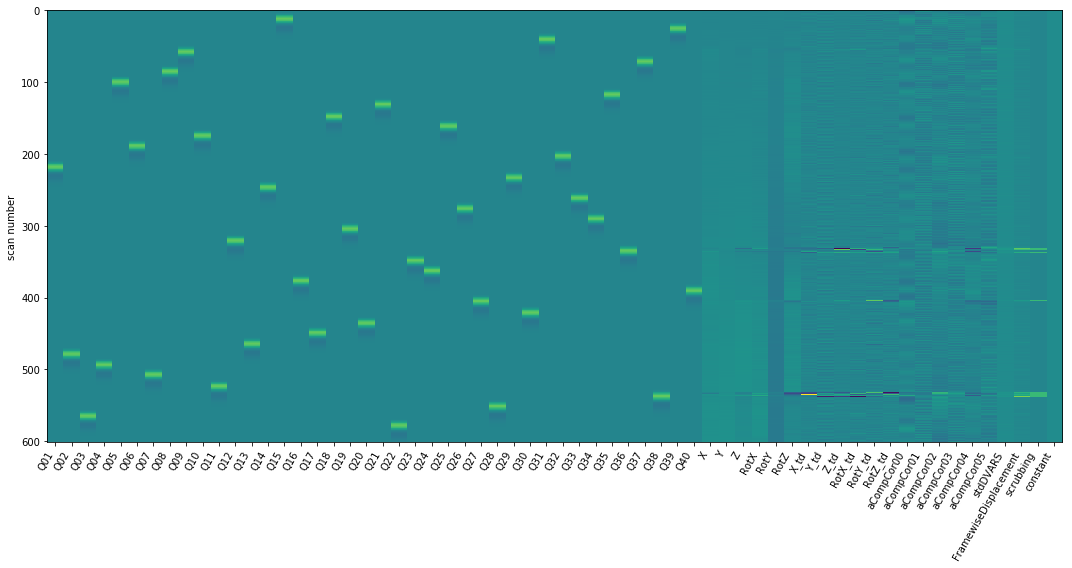

In [6]:
# define the model
fmri_glm = FirstLevelModel(tr, 
                           noise_model='ar1',
                           standardize=False, 
                           hrf_model='glover',
                           drift_model=None,
                           period_cut=160,
                          )

fmri_glm_non_smoothed = fmri_glm.fit(fmri, events, confounds=confounds_clean)
design_matrix = fmri_glm_non_smoothed.design_matrices_[0]
fig, ax = plt.subplots(figsize=(15,8))
plot_design_matrix(design_matrix, ax=ax)
fig.savefig(f'{out_dir}{sub}/figures/{sub}_design_matrix.png')


Defining contrast
=========================

/home/finc/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


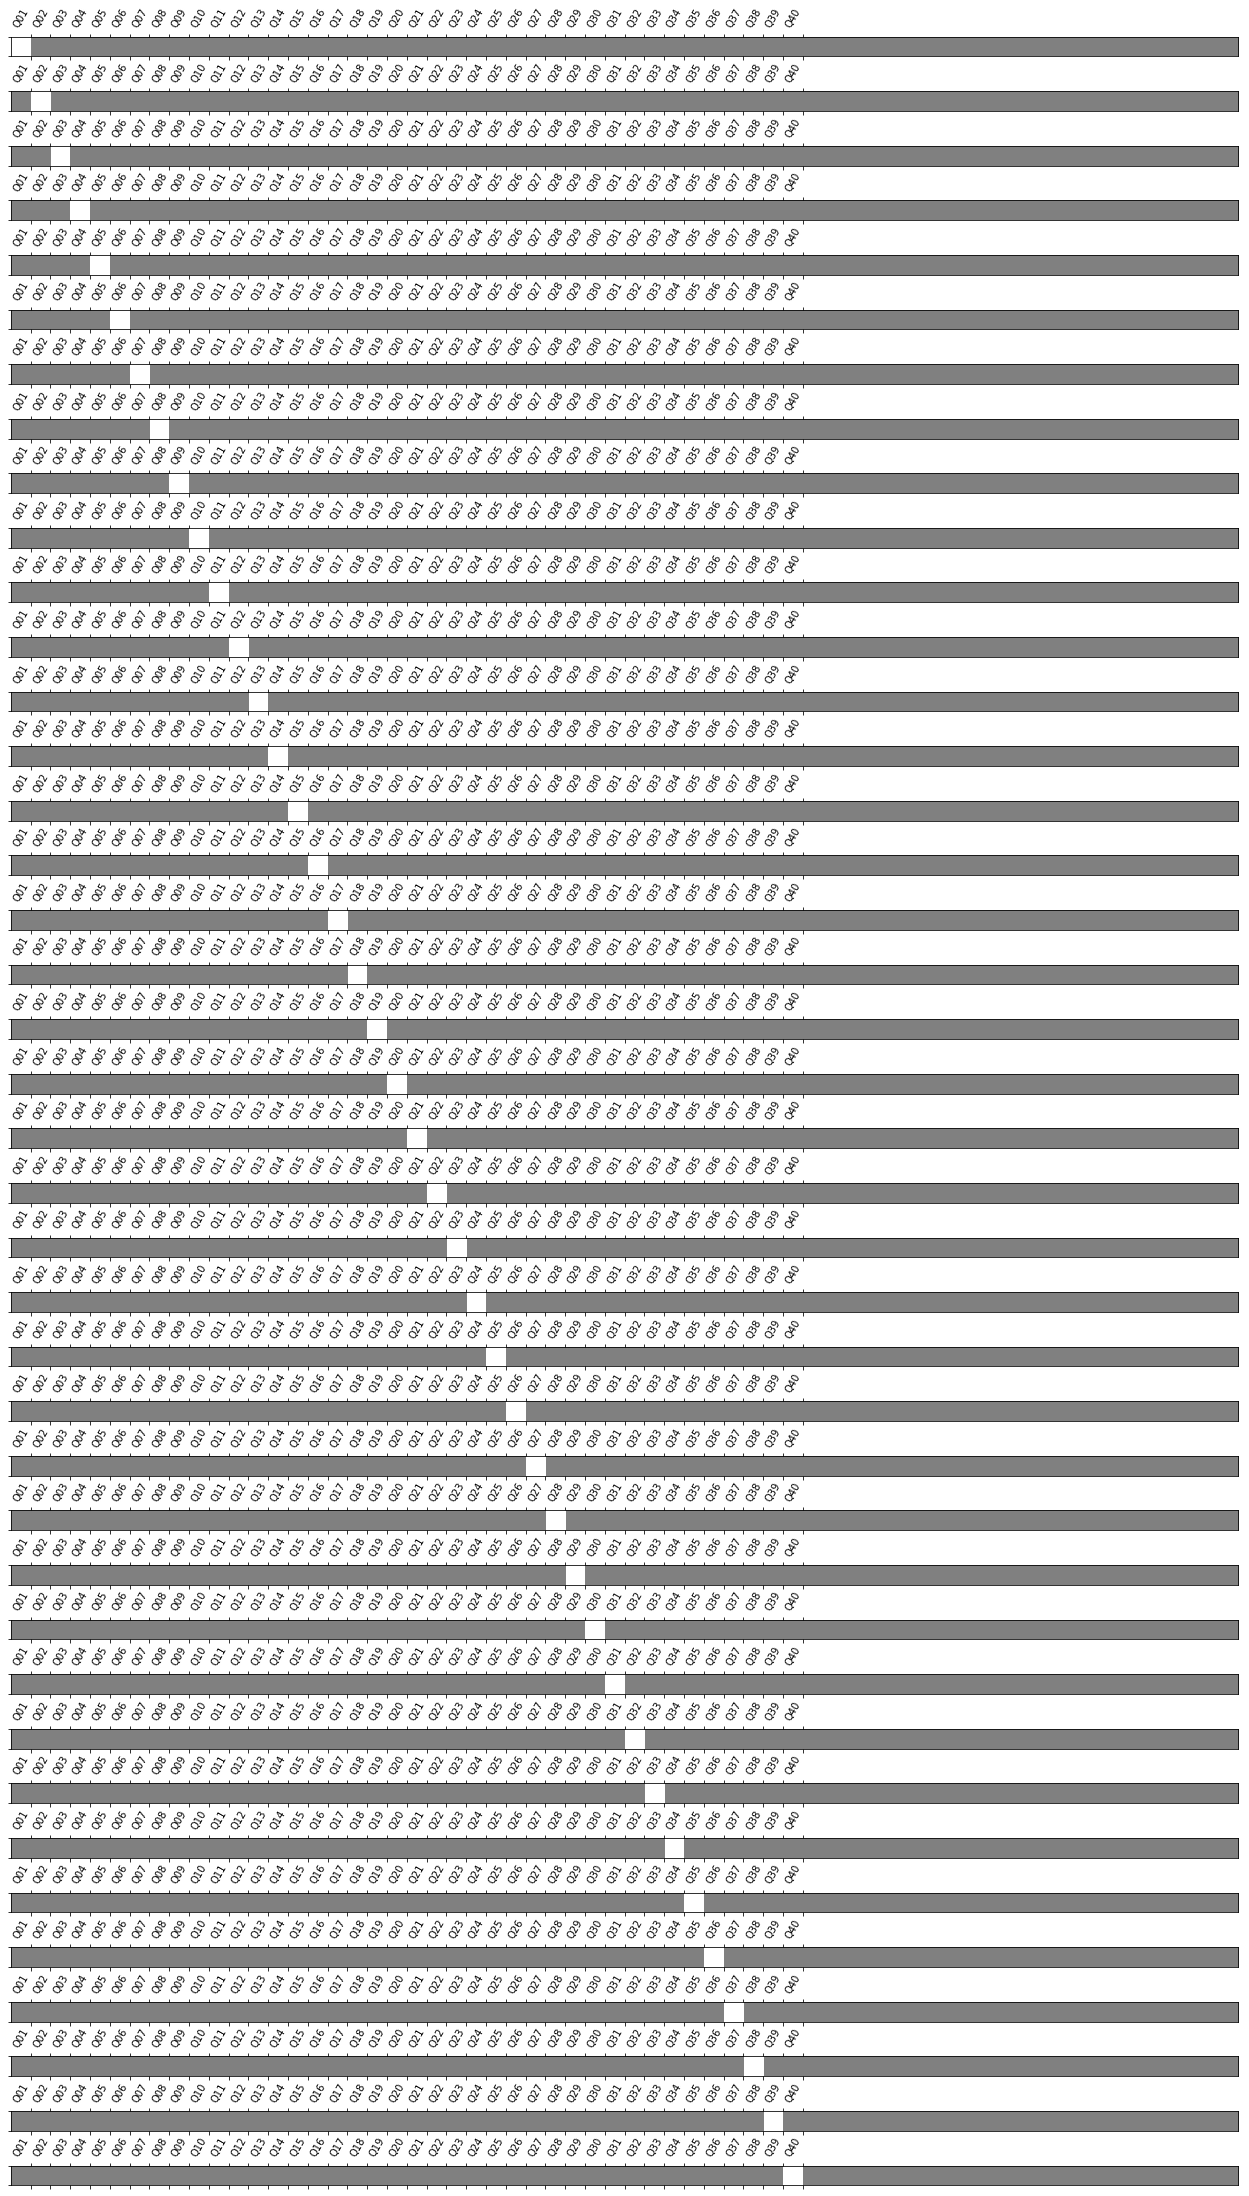

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
trial_dummies = pd.get_dummies(design_matrix.columns)
trial_contrasts = pd.DataFrame.to_dict(trial_dummies, orient = 'list')
trial_contrasts['overall'] = [1 if i[0] == 'Q' else 0 for i in design_matrix.columns]

fig, ax = plt.subplots(n_trials, 1)
fig.set_size_inches(22, 40)

for i in range(n_trials ):
    plt.figure()
    _ = plot_contrast_matrix(trial_contrasts[f'Q{i+1:02}'] , design_matrix=design_matrix.iloc[:,0:40], ax=ax[i])

fig.savefig(f'{out_dir}{sub}/figures/{sub}_contrasts_trials.png')

Trial effects estimation
------------------------------------

/home/finc/anaconda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


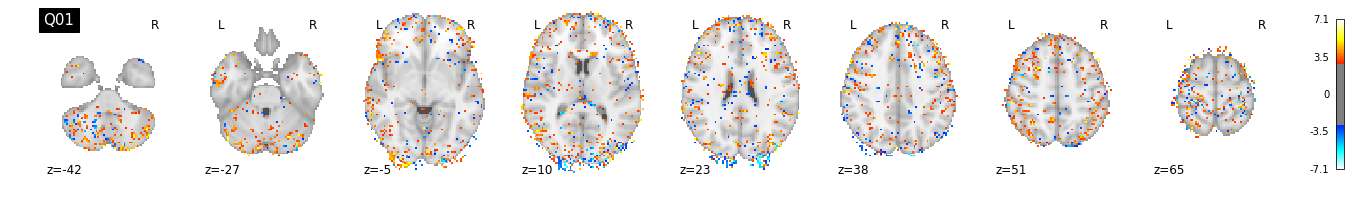

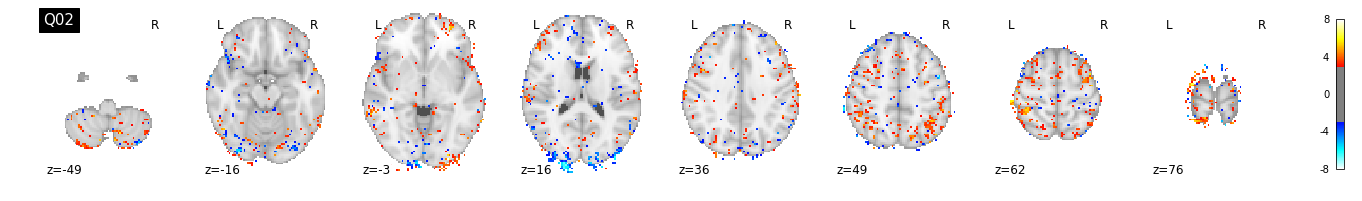

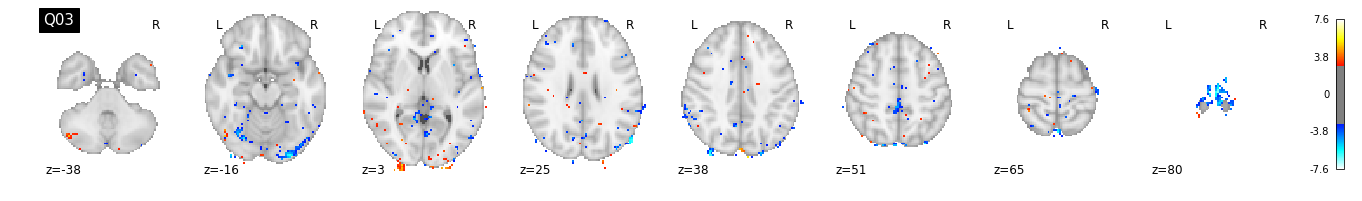

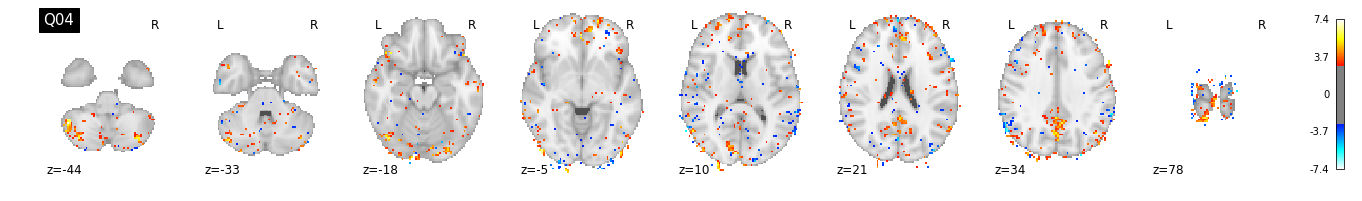

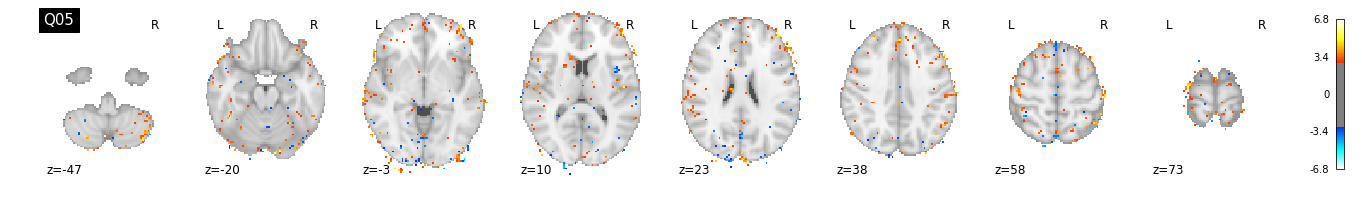

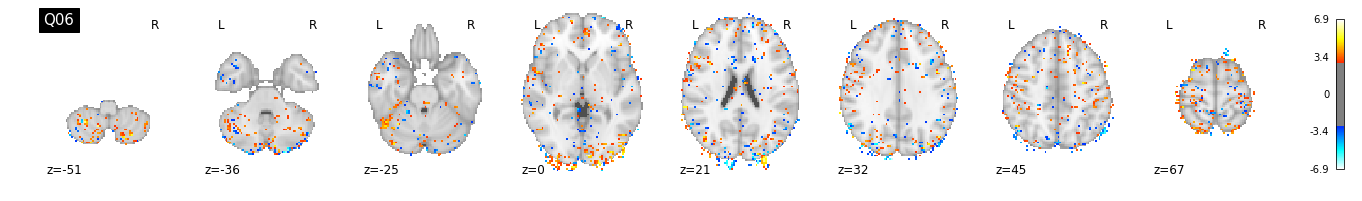

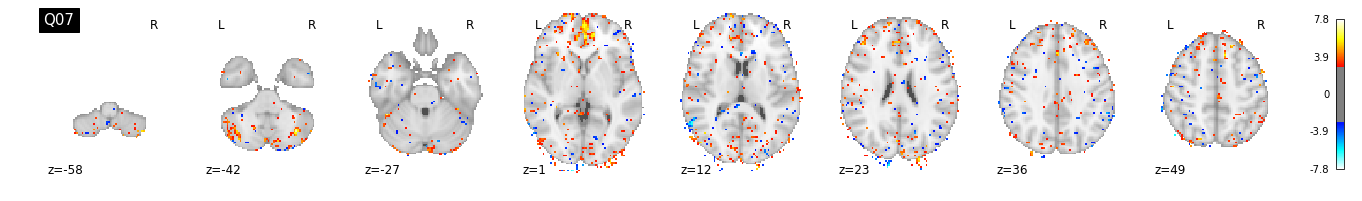

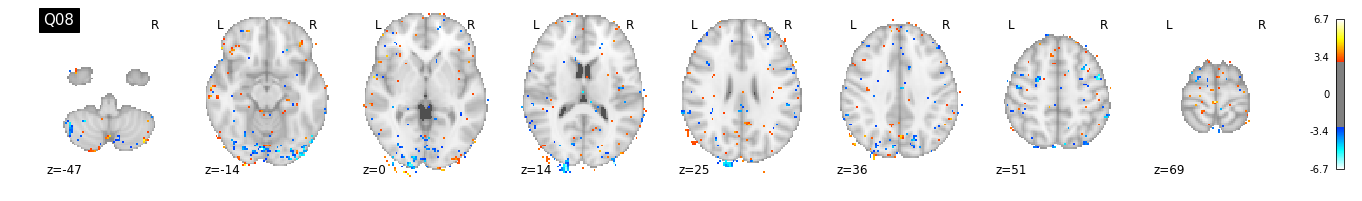

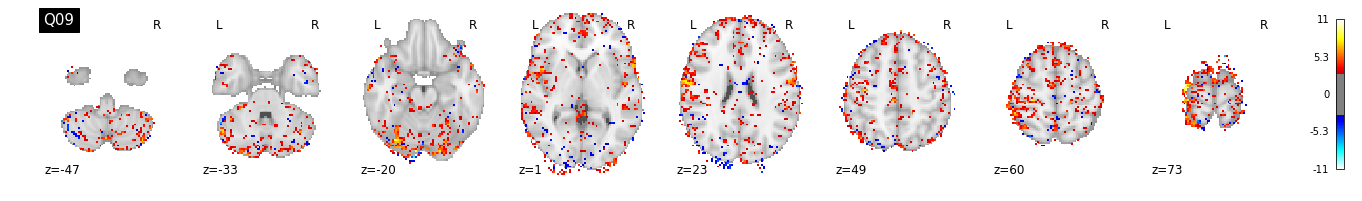

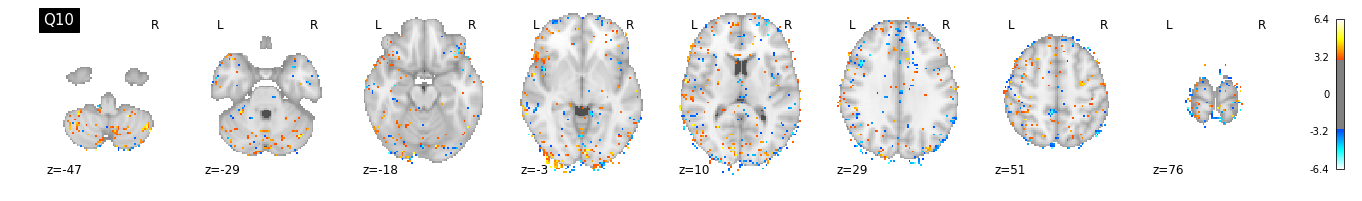

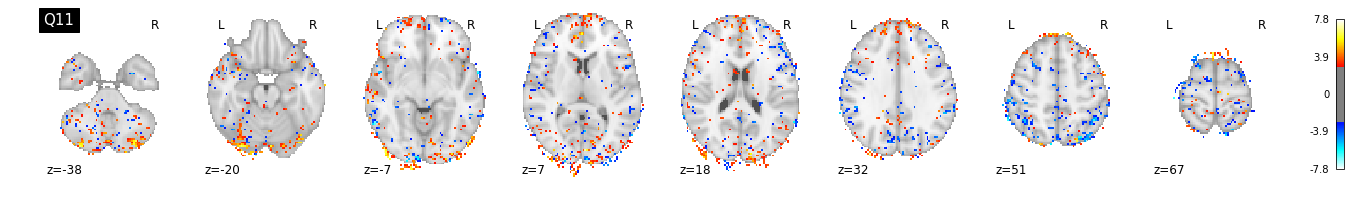

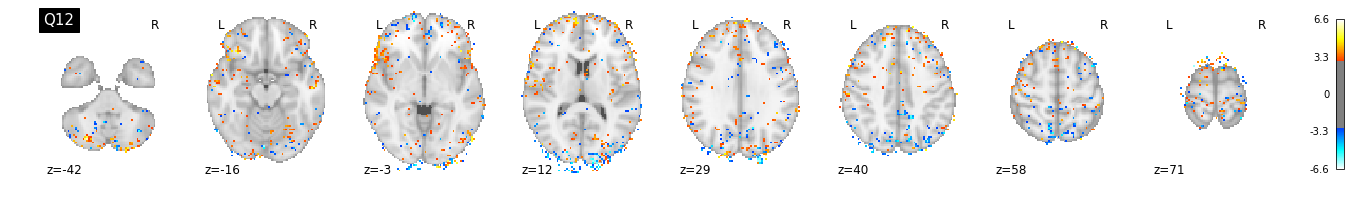

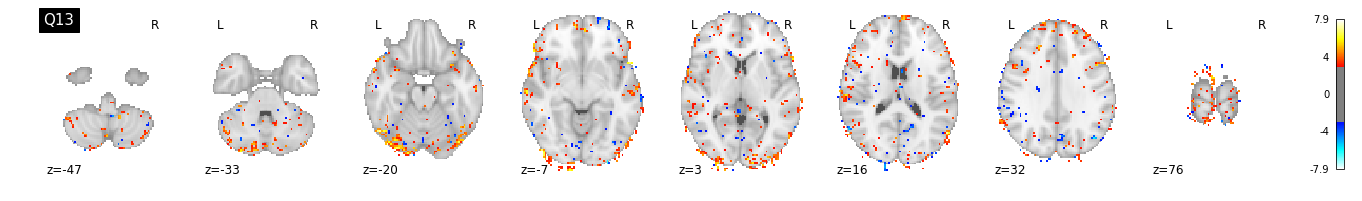

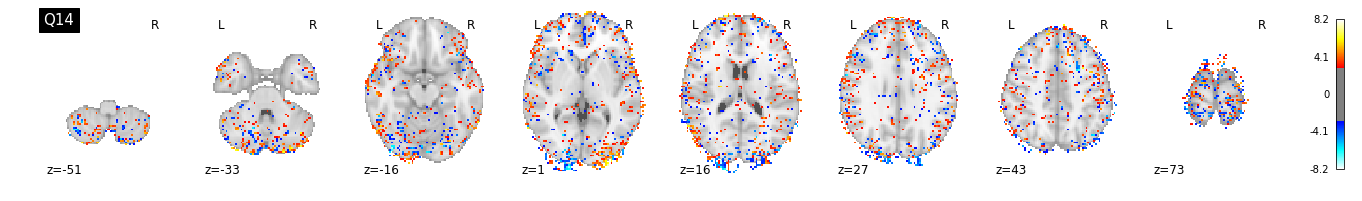

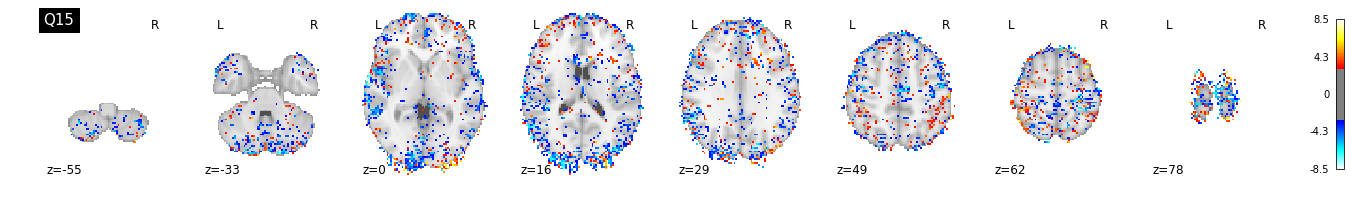

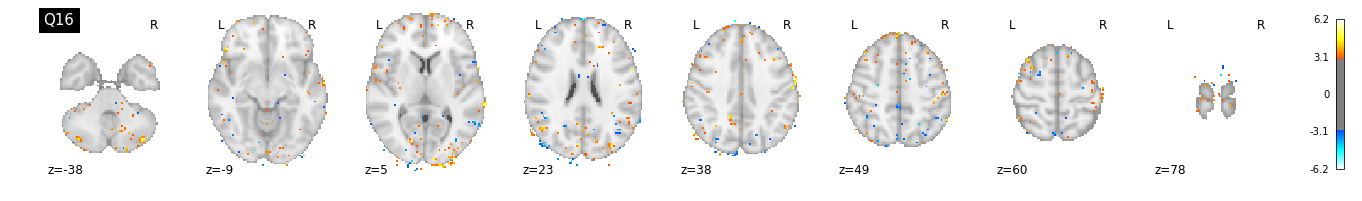

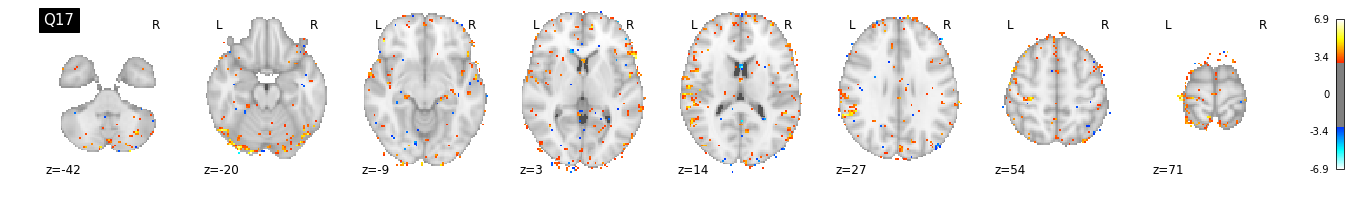

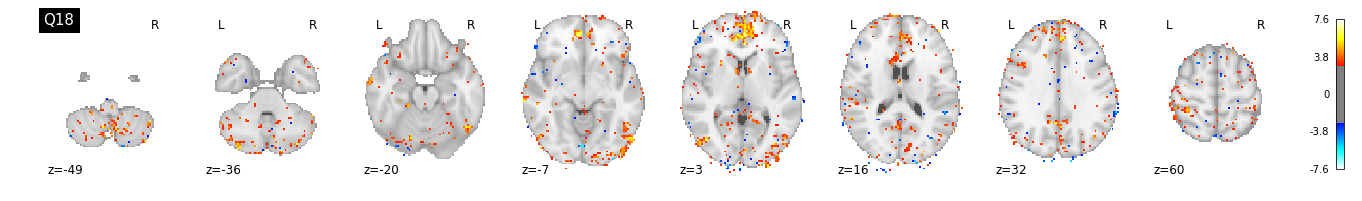

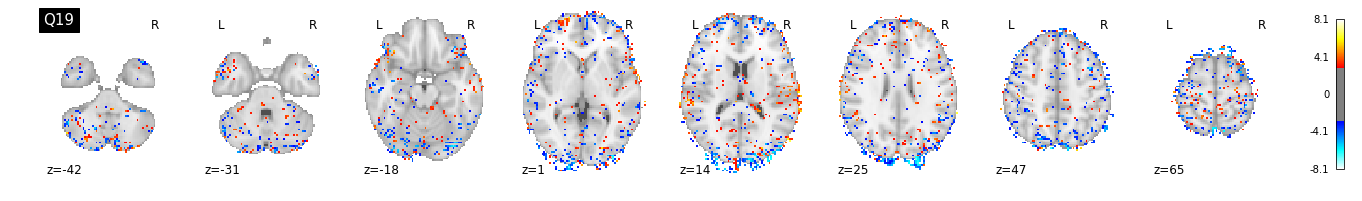

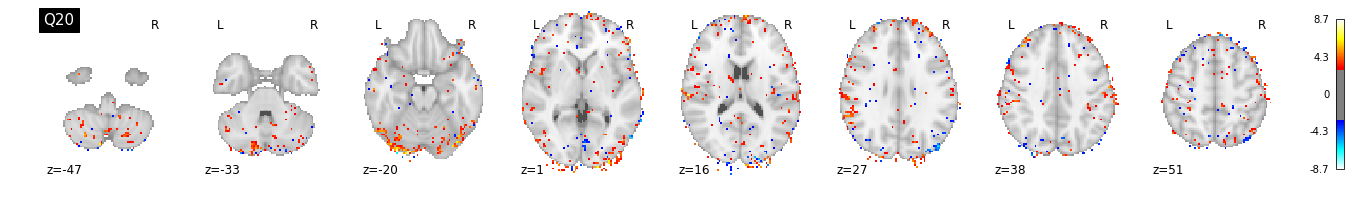

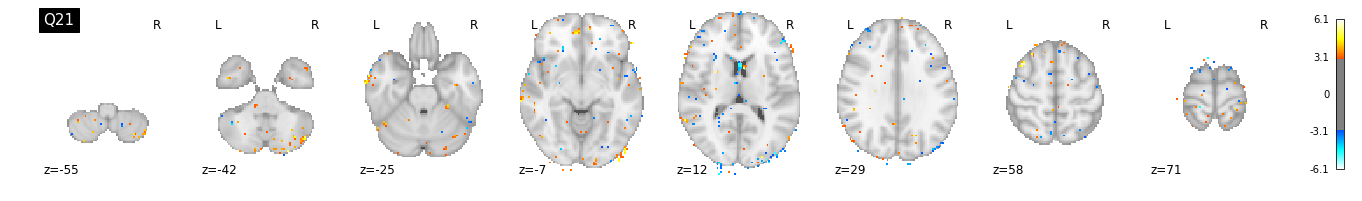

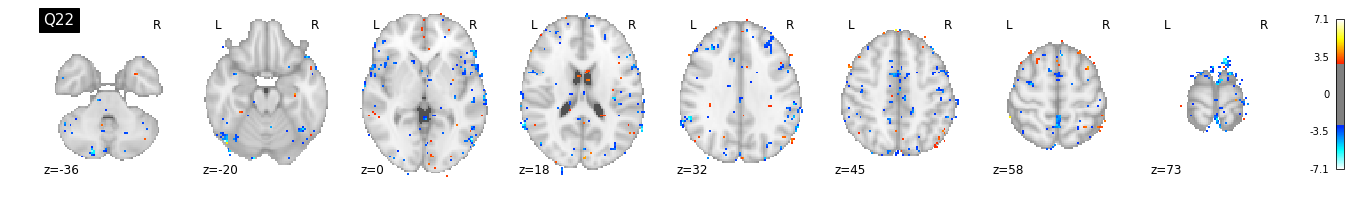

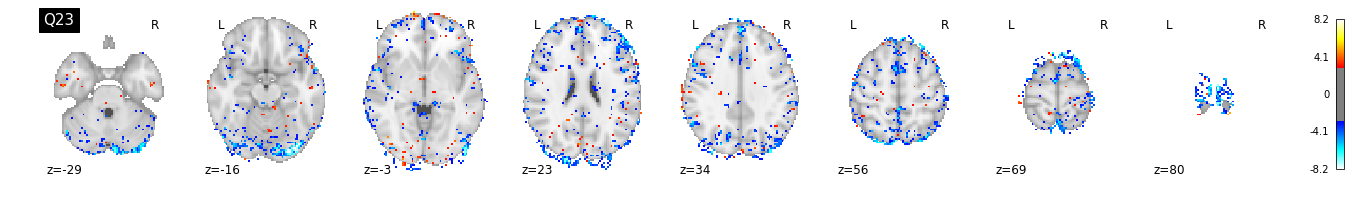

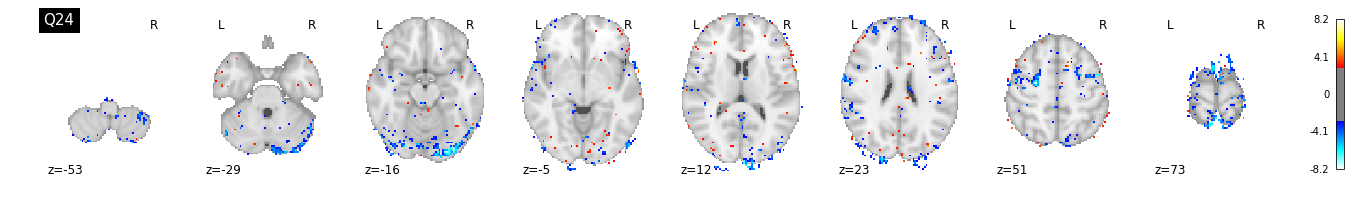

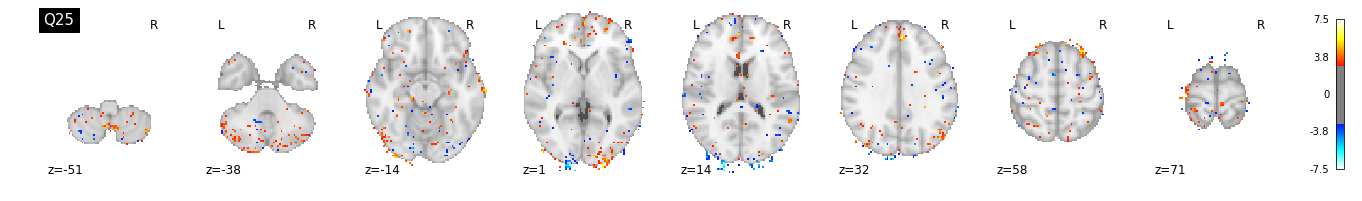

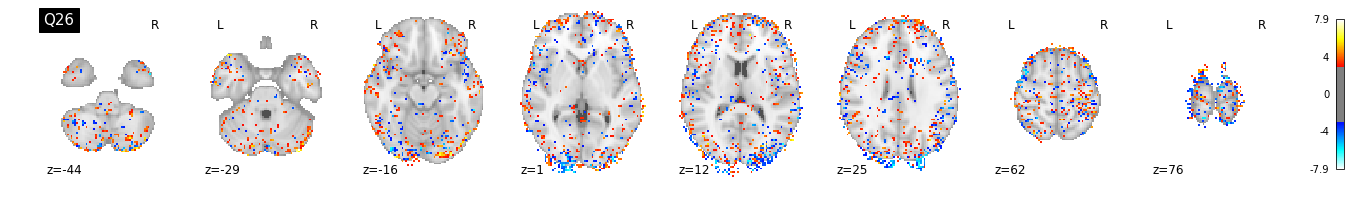

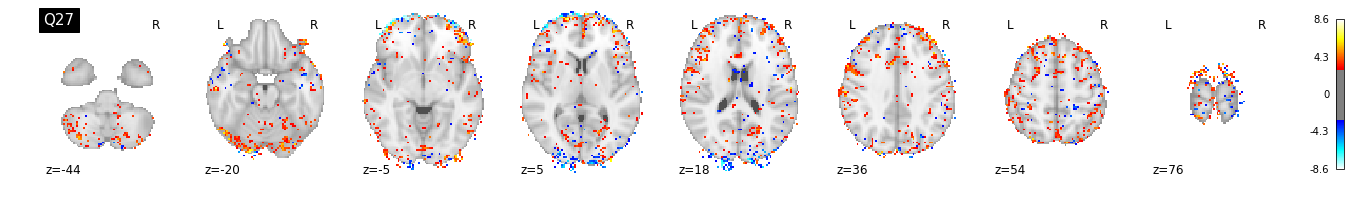

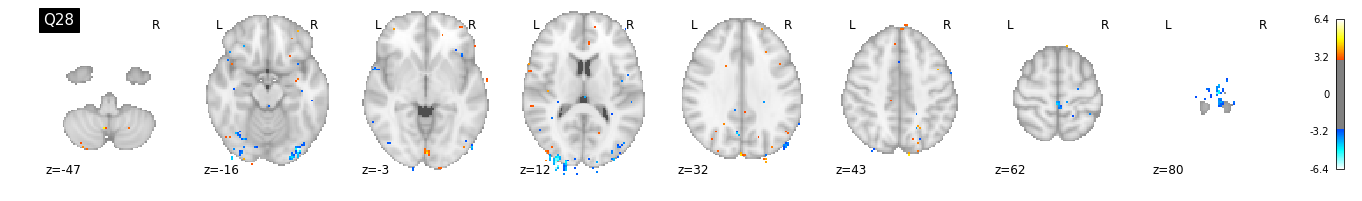

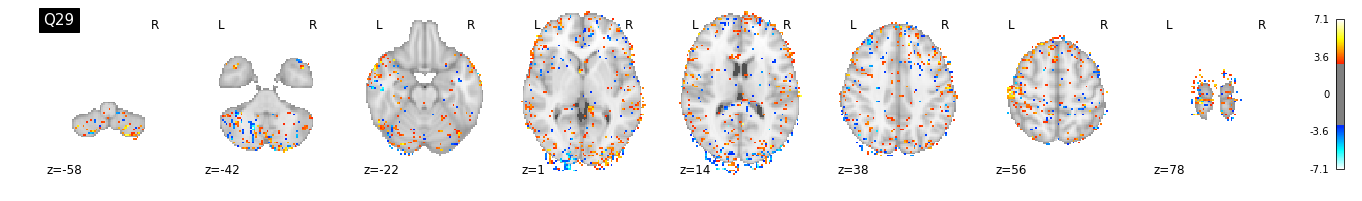

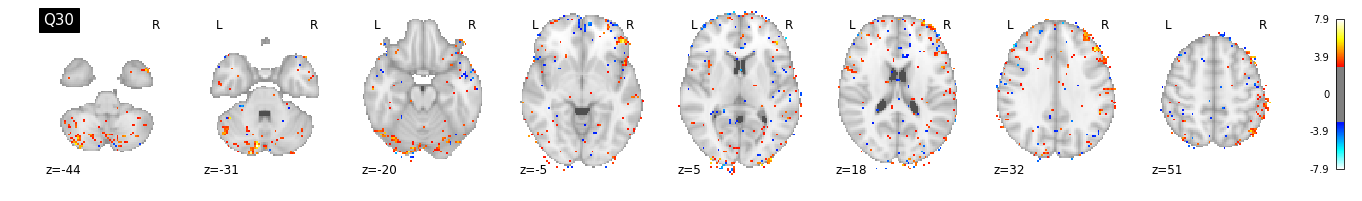

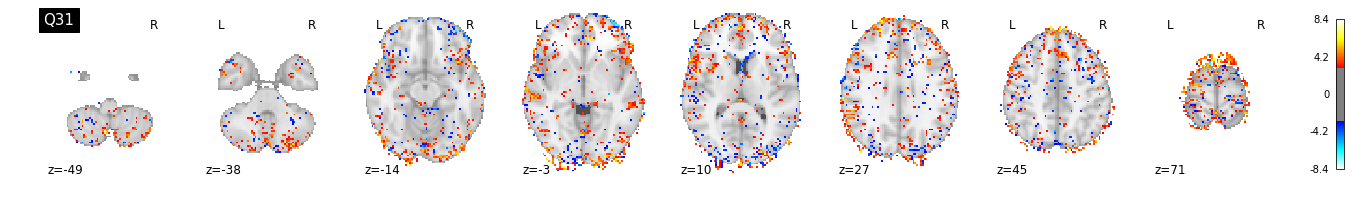

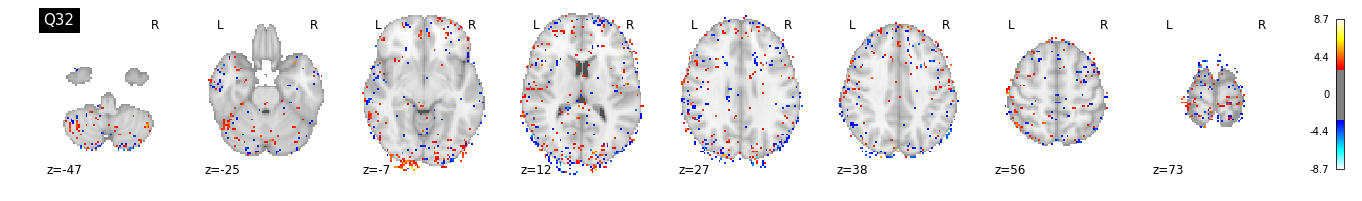

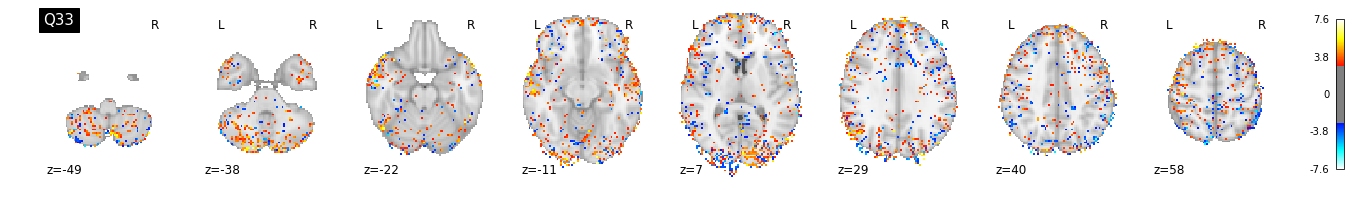

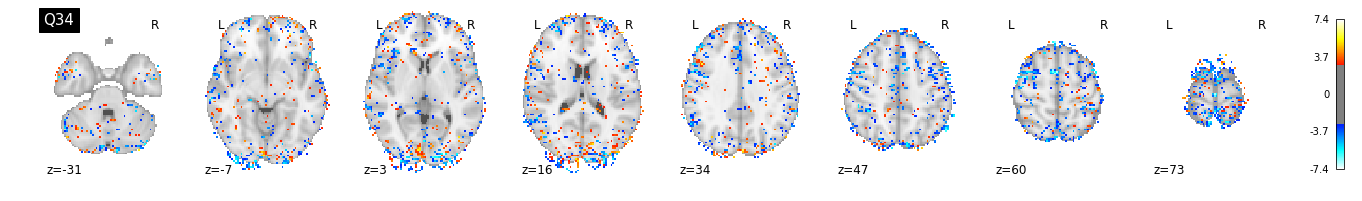

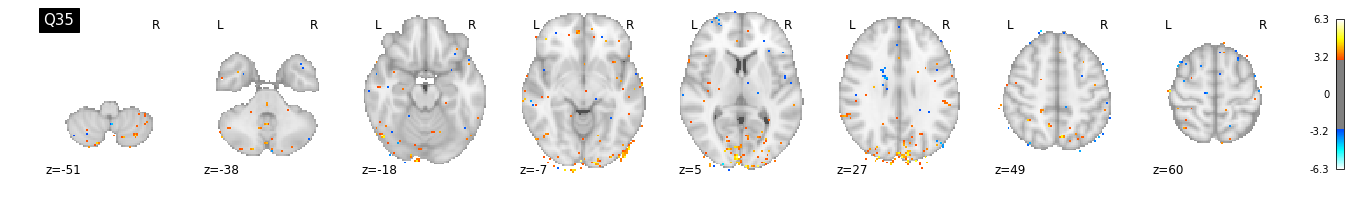

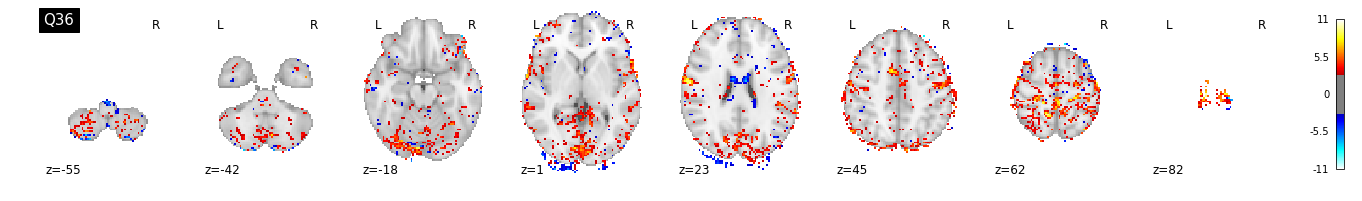

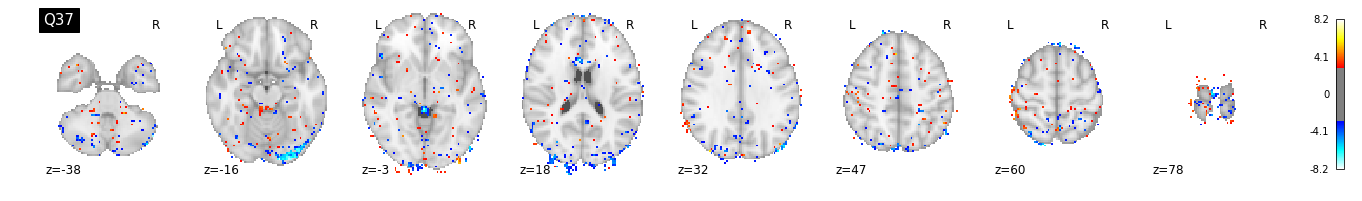

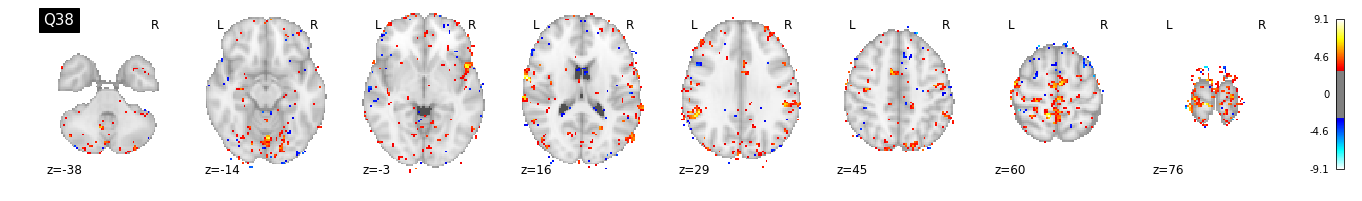

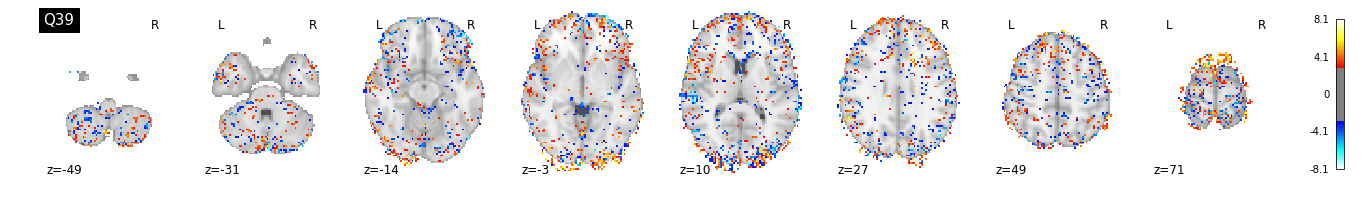

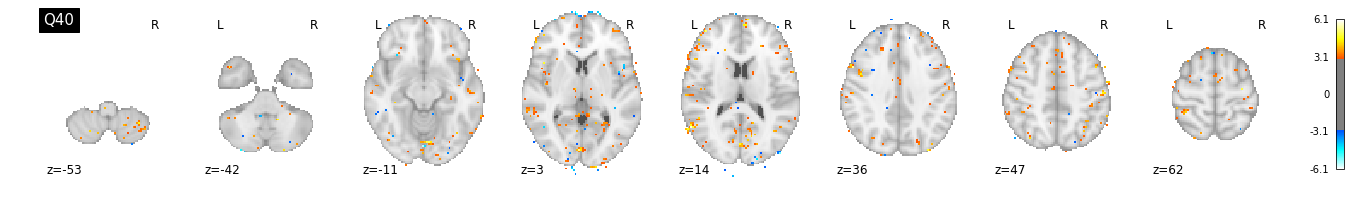

In [8]:
betas = np.zeros((89, 105, 89, n_trials))

for i in range(n_trials):
    beta = fmri_glm_non_smoothed.compute_contrast(np.asarray(trial_contrasts[f'Q{i+1:02}']), output_type='z_score')
    betas[:,:,:,i] = beta.get_fdata()
    p = plot_stat_map(beta, threshold=3,
              display_mode='z', cut_coords=8, black_bg=False,
              title='Q{:0>2d}'.format(i+1))
    p.savefig(f'{out_dir}{sub}/figures/{sub}_Q{i+1:02}_zmap.png')
    
beta_img = nib.Nifti1Image(betas, beta.affine, beta.header)
nib.save(beta_img, f'{out_dir}{sub}/{sub}_{task}_Q_all_zmaps.nii.gz')

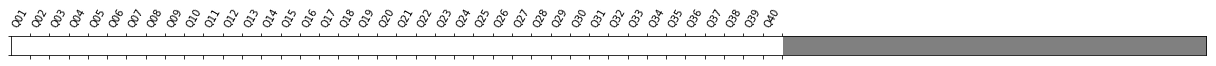

In [9]:
# Overall survey effect contrast
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(17, 3)
plot_contrast_matrix(trial_contrasts['overall'] , design_matrix=design_matrix.iloc[:,0:40], ax = ax)
fig.savefig(f'{out_dir}{sub}/figures/{sub}_contrast_overall.png')

In [10]:
fmri_img_smoothed = image.smooth_img(fmri_img, fwhm=4)
fmri_glm_smoothed = fmri_glm.fit(fmri_img_smoothed, events, confounds=confounds_clean)

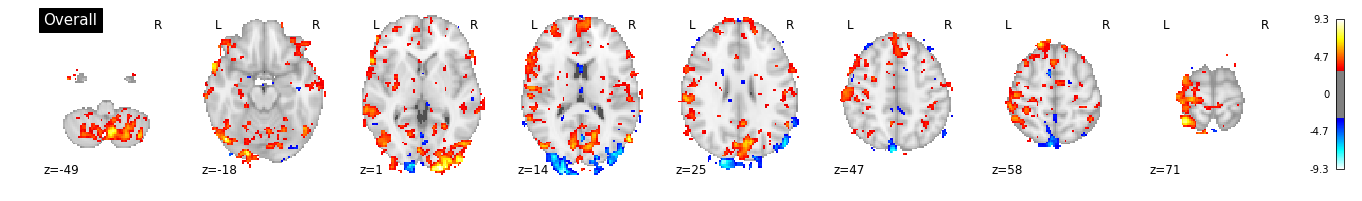

In [11]:
efect_of_survey = fmri_glm_smoothed.compute_contrast(np.asarray(trial_contrasts['overall']), output_type='z_score')

p = plot_stat_map(efect_of_survey, threshold=3,
              display_mode='z', cut_coords=8, black_bg=False,
              title='Overall')
fig.savefig(f'{out_dir}{sub}/figures/{sub}_Q_overall_zmap.png')


In [12]:
nib.save(efect_of_survey, f'{out_dir}{sub}/{sub}_{task}_Q_overal_zmap.nii.gz')